This BRATS Location Regression Model is based on Gabriel Atkin (2021) Age Prediction From Facial Images Model. Available at: https://www.kaggle.com/gcdatkin/age-prediction-from-images-cnn-regression [Last Accessed 30 July 2021]

## Save BRATS Images

In [ ]:
from google.colab import drive
import nibabel as nib
from scipy import ndimage
import os
from matplotlib import pyplot as plt
%matplotlib inline
import os.path

In [ ]:
# upload dataset here (deprecated for full dataset- using google drive mounting method)
# from google.colab import files
# datasetfile = files.upload()

# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# list to store slices
imgList = []
labelList = []

# index values which produce images
# sagittal (i = 51 --> i = 186)
# coronal  (i = 43 --> i = 218)
# axial    (i = 10 --> i = 142)

startIndex = 51
endIndex = 186

def store_img(file):
  bratsImg = nib.load(file)
  bratsImgData = bratsImg.get_fdata()

  i = startIndex
  while i < endIndex:
    # rotate images to 0 degrees + store in list - SAGITTAL
    rotatedImg = ndimage.rotate(bratsImgData[i,:,:], 90, mode = 'mirror')
    imgList.append(rotatedImg.copy())

    # store current index value
    labelList.append(i)

    i += 1

# extract 100 flair files from BRATS HGG data folders
dirHGG = '/content/drive/MyDrive/URVOS/Brats_2018_data.zip (Unzipped Files)/Brats_2018 data/HGG/'
count = 0
for folder in os.listdir(dirHGG):
  for file in os.listdir(dirHGG + folder + '/'):
    if count <= 100:
      if file.endswith("flair.nii.gz"):
        store_img(dirHGG + folder + '/' + file)
        count += 1

In [ ]:
# create directories for each label
mainDir = '/content/gdrive/bratsRegression/'

for i in range(startIndex, endIndex):
  if not os.path.exists(mainDir + str(i) + '/'):
      os.makedirs(mainDir + str(i) + '/')

In [ ]:
# add list images to corresponding directories
myPath = os.path.abspath(mainDir)

i = startIndex
j = 1
for img in imgList:
  if i == endIndex:
    i = startIndex
  plt.imsave(myPath + '/' + str(i) + '/' + str(j) + '.jpg', img)
  i += 1
  j += 1

## Create file dataframe

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
image_dir = Path('/content/gdrive/bratsRegression')

# retrieve image directories and location labels
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
locations = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Location').astype(np.int)

images = pd.concat([filepaths, locations], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

images

,Filepath,Location
0,/content/gdrive/bratsRegression/165/9160.jpg,165
1,/content/gdrive/bratsRegression/116/2091.jpg,116
2,/content/gdrive/bratsRegression/54/2299.jpg,54
3,/content/gdrive/bratsRegression/137/11832.jpg,137
4,/content/gdrive/bratsRegression/155/2535.jpg,155
...,...,...
13630,/content/gdrive/bratsRegression/164/3624.jpg,164
13631,/content/gdrive/bratsRegression/173/4578.jpg,173
13632,/content/gdrive/bratsRegression/143/4413.jpg,143
13633,/content/gdrive/bratsRegression/120/3310.jpg,120


In [ ]:
# only use 5000 images to speed up training time
#image_df = images.sample(5000, random_state=1).reset_index(drop=True)
image_df = images

# assign 70% of images to train set
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

## Load Images

In [ ]:
import tensorflow as tf

In [ ]:
# specify transformations
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # test set at 20%
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Location',
    target_size=(240, 240),
    class_mode='raw',
    batch_size=25,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Location',
    target_size=(240, 240),
    class_mode='raw',
    batch_size=25,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Location',
    target_size=(240, 240),
    class_mode='raw',
    batch_size=25,
    shuffle=False
)

Found 7636 validated image filenames.
Found 1908 validated image filenames.
Found 4091 validated image filenames.


## Training

In [ ]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=5,
                   restore_best_weights=True
                   )
               ]
)

Epoch 1/100
306/306 [==============================] - 51s 72ms/step - loss: 1919.6090 - val_loss: 1506.0885
Epoch 2/100
306/306 [==============================] - 22s 71ms/step - loss: 1555.8458 - val_loss: 1517.5074
Epoch 3/100
306/306 [==============================] - 22s 71ms/step - loss: 1536.8691 - val_loss: 1552.0156
Epoch 4/100
306/306 [==============================] - 22s 71ms/step - loss: 1563.0172 - val_loss: 1496.1128
Epoch 5/100
306/306 [==============================] - 22s 71ms/step - loss: 1550.8329 - val_loss: 1476.6542
Epoch 6/100
306/306 [==============================] - 22s 72ms/step - loss: 1515.5597 - val_loss: 1494.3953
Epoch 7/100
306/306 [==============================] - 22s 71ms/step - loss: 1512.5165 - val_loss: 1464.7815
Epoch 8/100
306/306 [==============================] - 22s 70ms/step - loss: 1501.7694 - val_loss: 1460.2456
Epoch 9/100
306/306 [==============================] - 22s 71ms/step - loss: 1536.1798 - val_loss: 1464.5515
Epoch 10/100
306/30

## Results

In [ ]:
from sklearn.metrics import r2_score

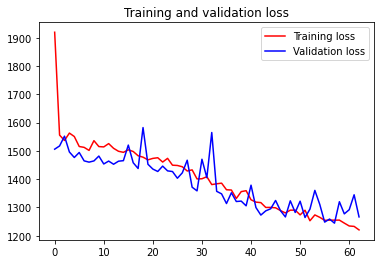

<Figure size 432x288 with 0 Axes>

Test RMSE: 35.92353
Test R^2 Score: 16.05037%


In [ ]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

predicted_locations = np.squeeze(model.predict(test_images))
true_locations = test_images.labels

# root mean square error - average distance between the predicted values from the model and the actual values in the dataset
rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

# r2 score - to what extent the variance of one variable explains the variance of the second variable
r2 = r2_score(true_locations, predicted_locations)
print("Test R^2 Score: {:.5f}%".format(r2*100))

In [ ]:
#test out-of-sample images by SEPERATE UPLOAD
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (240,240))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  location = model.predict(images, batch_size=1)
  print("\nLocation: " + str(round(location[0][0])))

Saving sag100.jpg to sag100.jpg

Location: 114
